In [1]:
import time
import numpy as np
import torch
from d2l import torch as d2l
from torch import nn

In [2]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class,obj.__name__,obj)
    return wrapper

In [3]:
class A:
    def __init__(self):
        self.b = 1
a = A()

In [4]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is',self.b )

a.do()

Class attribute "b" is 1


In [8]:
class HyperParameter:
    def save_hyperparameters(self , ignore = []):
        raise NotImplemented

In [7]:
class B(d2l.HyperParameters):
    def __init__(self , a , b , c ):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b = ',self.b)
        print('There is no self.c = ' , not hasattr(self , 'c'))
b = B(a = 1 , b = 2 , c = 3)

self.a = 1 self.b =  2
There is no self.c =  True


In [9]:
class ProgressBoard(d2l.HyperParameters):
    def __init__(self , xlabel=None , ylabel=None , xlim=None,
                 ylim=None,xscale='linear',yscale='linear',
                 ls=['--','--','-.',':'],colors=['C0','C1','C2','C3'],
                 fig=None, axes=None, figsize = (3.5,2.5),display=True):
        self.save_hyperparameters()
    def draw(self,x,y,label,every_n = 1):
        raise NotImplemented
        

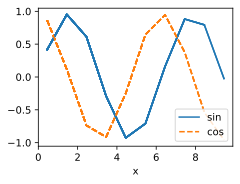

In [12]:
board = d2l.ProgressBoard('x')
for x in np.arange(0 , 10 , 0.1):
    board.draw(x,np.sin(x), 'sin',every_n=10)
    board.draw(x, np.cos(x), 'cos', every_n = 10)

In [13]:
class Module(nn.Module,d2l.HyperParameters):
    def __init__(self , plot_train_epoch,plot_valid_per_epoch = 1):
        super().__init__()

    def loss(self , y_hat , y):
        raise NotImplementedError
    
    def forward(self,X):
        assert hasattr(self,'net')
        return self.net(X)
    
    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)

    def configure_optimizers(self):
        raise NotImplementedError

In [14]:
class DataModule(d2l.HyperParameters):  #@save
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [15]:
class Trainer(d2l.HyperParameters):  #@save
    """The base class for training models with data."""
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support yet'

    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        self.model = model

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def fit_epoch(self):
        raise NotImplementedError

In [ ]:
def synthetic_data(w, b, num_examples):  #@save
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [20]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.0367, -2.0347]) 
label: tensor([11.0587])


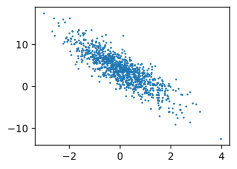

In [22]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [3]:
def matrix_multiplication(matrix1, matrix2):
    m = len(matrix1)
    n = len(matrix1[0])
    p = len(matrix2[0])
    if n != len(matrix2):
        raise ValueError("列不等于行")
    result = [[0 for _ in range(p)] for _ in range(m)]
    for i in range(m):
        for j in range(p):
            for k in range(n):
                result[i][j] += matrix1[i][k] * matrix2[k][j]
    return result

matrix1 = [[1, 2, 3], [4, 5, 6]]
matrix2 = [[7, 8], [9, 10], [11, 12]]
result = matrix_multiplication(matrix1, matrix2)
print("矩阵相乘的结果：")
for row in result:
    print(row)

矩阵相乘的结果：
[58, 64]
[139, 154]


In [ ]:
import numpy as np


def gaussian_elimination(A, b):
    n = len(A)
    augmented_matrix = np.hstack((A, b.reshape(-1, 1)))

    for i in range(n):
        max_row = np.argmax(np.abs(augmented_matrix[i:, i])) + i
        augmented_matrix[[i, max_row]] = augmented_matrix[[max_row, i]]

        if augmented_matrix[i, i] == 0:
            raise ValueError("矩阵是奇异的，方程组无解或有无穷多解")

        for j in range(i + 1, n):
            factor = augmented_matrix[j, i] / augmented_matrix[i, i]
            augmented_matrix[j, i:] -= factor * augmented_matrix[i, i:]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (augmented_matrix[i, -1] - np.dot(augmented_matrix[i, i + 1:-1], x[i + 1:])) / augmented_matrix[i, i]

    return x


A = np.array([[2, 1, -1],
              [-3, -1, 2],
              [-2, 1, 2]], dtype=float)
b = np.array([8, -11, -3], dtype=float)

try:
    solution = gaussian_elimination(A, b)
    print("方程组的解为:", solution)
except ValueError as e:
    print(e)
    

方程组的解为: [ 2.  3. -1.]
